# Results figure --- contribution of rivers to flux of Mn across boundaries

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
from itertools import compress
import datetime as dt
import os
from matplotlib.ticker import FormatStrFormatter, MultipleLocator
import matplotlib.dates as mdates

%matplotlib inline

#### Parameters:

In [2]:
# domain dimensions:
imin, imax = 1479, 2179
jmin, jmax = 159, 799
isize = imax-imin
jsize = jmax-jmin

# model result set:
folder_ref  = '/data/brogalla/run_storage/Mn-reference-202206/'
folder_glac = '/data/brogalla/run_storage/river-glacial-202206/'
folder_cont = '/data/brogalla/run_storage/river-continental-202206/'

# Colors:
color_glac_dark = '#05507d'
color_glac = '#0873b4'
color_cont = '#ab5c29'

# Years to include:
years = [2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, \
         2016, 2017, 2018, 2019, 2020]

In [3]:
# Coordinates of boundaries:
xmin = imin+1; ymin=jmin+1
l2i = 1935-xmin; l2j = np.arange(450-ymin,530-ymin)  # Parry Channel western XS ##2
P1i = 1585-xmin; P1j = np.arange(485-ymin,538-ymin)  # Parry Channel eastern XS ##11
r1i = 1520-xmin; r1j = np.arange(505-ymin,673-ymin)  # Baffin Bay XS            ##8
t1i = np.arange(1635-xmin,1653-xmin); t1j = 760-ymin # Nares Strait northern XS ##7
N1i = np.arange(1570-xmin,1630-xmin); N1j = 635-ymin # Nares Strait southern XS ##10

#### Load files:

In [4]:
# ANHA12 grid file:
mesh       = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
tmask      = np.array(mesh.variables['tmask'])[0,:,imin:imax,jmin:jmax]
land_mask  = np.ma.masked_where((tmask[:,:,:] > 0.1), tmask[:,:,:]) 
lons       = np.array(mesh.variables['nav_lon'])
lats       = np.array(mesh.variables['nav_lat'])
depths     = np.array(mesh.variables['gdept_1d'])[0,:]
e1t_base   = np.array(mesh.variables['e1t'])[0,imin:imax,jmin:jmax]
e2t_base   = np.array(mesh.variables['e2t'])[0,imin:imax,jmin:jmax]
e3t        = np.array(mesh.variables['e3t_0'])[0,:,imin:imax,jmin:jmax]
e3t_masked = np.ma.masked_where((tmask[:,:,:] < 0.1), e3t)

#### Functions:

In [5]:
def time_series_pickle(experiment, year):
    folder = '/ocean/brogalla/GEOTRACES/time-series/'
    
    # --- Coordinates of boundaries ---
    # Parry Channel western XS -- 2
    # Parry Channel eastern XS -- 11
    # Baffin Bay XS            -- 8
    # Nares Strait northern XS -- 7
    # Nares Strait southern XS -- 10
    
    # Load calculated time series of fluxes:
    time_series_V1, time_series_V2, time_series_V3, time_series_V4, time_series_V5, time_series_V6,time_series_V7,\
    time_series_V8, time_series_V9, time_series_V10, time_series_V11, time_series_mn1, time_series_mn2, \
    time_series_mn3, time_series_mn4, time_series_mn5, time_series_mn6, time_series_mn7, time_series_mn8, \
    time_series_mn9, time_series_mn10, time_series_mn11 = \
        pickle.load(open(f'{folder}{experiment}/time-series-{year}.pickle','rb'))  

    # convert mn from mol m3/L s --> mol /s by multiplying by 1e3
    return time_series_mn2*1e3, time_series_mn11*1e3, time_series_mn8*1e3, time_series_mn7*1e3, time_series_mn10*1e3

In [6]:
def file_dates(year):
    #start_date and end_date are datetime objects
    start_date = dt.datetime(year,1,1)
    end_date   = dt.datetime(year,12,31)
    
    if year < 2019:
        file_list1 = np.sort(os.listdir(f'{folder_glac}ANHA12_glacial-{year}_20220607/'))
    else:
        file_list1 = np.sort(os.listdir(f'{folder_glac}ANHA12_glacial-{year}_20220621/'))
    file_list2 = np.sort(os.listdir('/data/brogalla/ANHA12/'))
    
    Vlist = [i[26:31]=='gridV' for i in file_list2]
    gridV_list = list(compress(file_list2, Vlist))
    dateV_list = [dt.datetime.strptime(i[14:25], "y%Ym%md%d") for i in gridV_list]
    gridV_file_list = list(compress(gridV_list, [V > start_date and V < end_date for V in dateV_list]))
    
    dates = [dt.datetime.strptime(i[14:25], "y%Ym%md%d") for i in gridV_file_list]
    
    return dates

#### Calculations:

In [8]:
ref_PCW  = np.empty((len(years),72,50,79)); ref_PCE  = np.empty((len(years),72,50,52)); # reference experiment
glac_PCW = np.empty((len(years),72,50,79)); glac_PCE = np.empty((len(years),72,50,52)); # glacial-enhanced experiment
cont_PCW = np.empty((len(years),72,50,79)); cont_PCE = np.empty((len(years),72,50,52)); # continental-enhanced experiment

ref_NSN  = np.empty((len(years),72,50,17)); ref_NSS  = np.empty((len(years),72,50,59)); 
glac_NSN = np.empty((len(years),72,50,17)); glac_NSS = np.empty((len(years),72,50,59)); 
cont_NSN = np.empty((len(years),72,50,17)); cont_NSS = np.empty((len(years),72,50,59)); 

ref_BB   = np.empty((len(years),72,50,167)) 
glac_BB  = np.empty((len(years),72,50,167))
cont_BB  = np.empty((len(years),72,50,167))

ref_PCW[:]  = np.nan; ref_PCE[:]  = np.nan; ref_NSN[:]  = np.nan; ref_NSS[:]  = np.nan; ref_BB[:] = np.nan;
glac_PCW[:] = np.nan; glac_PCE[:] = np.nan; glac_NSN[:] = np.nan; glac_NSS[:] = np.nan; glac_BB[:]= np.nan;
cont_PCW[:] = np.nan; cont_PCE[:] = np.nan; cont_NSN[:] = np.nan; cont_NSS[:] = np.nan; cont_BB[:]= np.nan;

# Calculate time series for each year:
for i, year in enumerate(years):
    yref_PCW,  yref_PCE,  yref_BB,  yref_NSN,  yref_NSS  = time_series_pickle('Mn-reference-202206'     , year)
    yglac_PCW, yglac_PCE, yglac_BB, yglac_NSN, yglac_NSS = time_series_pickle('river-glacial-202206'    , year)
    ycont_PCW, ycont_PCE, ycont_BB, ycont_NSN, ycont_NSS = time_series_pickle('river-continental-202206', year)
    
    if year < 2020:
        ref_PCW[i,:,:,:]  = yref_PCW;  ref_PCE[i,:,:,:]  = yref_PCE;
        glac_PCW[i,:,:,:] = yglac_PCW; glac_PCE[i,:,:,:] = yglac_PCE;
        cont_PCW[i,:,:,:] = ycont_PCW; cont_PCE[i,:,:,:] = ycont_PCE;

        ref_BB[i,:,:,:]   = yref_BB
        glac_BB[i,:,:,:]  = yglac_BB
        cont_BB[i,:,:,:]  = ycont_BB

        ref_NSN[i,:,:,:]  = yref_NSN;  ref_NSS[i,:,:,:]  = yref_NSS;
        glac_NSN[i,:,:,:] = yglac_NSN; glac_NSS[i,:,:,:] = yglac_NSS;
        cont_NSN[i,:,:,:] = ycont_NSN; cont_NSS[i,:,:,:] = ycont_NSS;
    elif year==2020: # only 70 files b/c end of run
        ref_PCW[i,0:70,:,:]  = yref_PCW;  ref_PCE[i,0:70,:,:]  = yref_PCE;
        glac_PCW[i,0:70,:,:] = yglac_PCW; glac_PCE[i,0:70,:,:] = yglac_PCE;
        cont_PCW[i,0:70,:,:] = ycont_PCW; cont_PCE[i,0:70,:,:] = ycont_PCE;

        ref_BB[i,0:70,:,:]   = yref_BB
        glac_BB[i,0:70,:,:]  = yglac_BB
        cont_BB[i,0:70,:,:]  = ycont_BB

        ref_NSN[i,0:70,:,:]  = yref_NSN;  ref_NSS[i,0:70,:,:]  = yref_NSS;
        glac_NSN[i,0:70,:,:] = yglac_NSN; glac_NSS[i,0:70,:,:] = yglac_NSS;
        cont_NSN[i,0:70,:,:] = ycont_NSN; cont_NSS[i,0:70,:,:] = ycont_NSS;        

In [9]:
# Array of 5-day file dates
dates = np.array([])
for year in range(2002, 2021):
    dates = np.append(dates, file_dates(year))

In [10]:
print(ref_PCW.shape) # year, 5 day, depth, grid points --- Mn is in mol/s for each grid point

(19, 72, 50, 79)


In [11]:
def proportion_above_ref(ref_flux, exp_flux, cumulative=False, multiple=np.nan):
    # Shape of input arrays of Mn fluxes: (years, 5-day, depths, grid points)
    
    # Create arrays of only the negative fluxes:
    ref_flux_neg = np.copy(ref_flux)
    exp_flux_neg = np.copy(exp_flux)
    ref_flux_neg[ref_flux > 0] = 0
    exp_flux_neg[exp_flux > 0] = 0
    
    # Create arrays of only the positive fluxes:
    ref_flux_pos = np.copy(ref_flux)
    exp_flux_pos = np.copy(exp_flux)
    ref_flux_pos[ref_flux < 0] = 0
    exp_flux_pos[exp_flux < 0] = 0
    
    # Flux for each 5-day period, seperated into negative and positive fluxes:
    ref_5d_neg = np.sum(ref_flux_neg, axis=(2,3)).flatten()
    ref_5d_pos = np.sum(ref_flux_pos, axis=(2,3)).flatten()
    exp_5d_neg = np.sum(exp_flux_neg, axis=(2,3)).flatten()
    exp_5d_pos = np.sum(exp_flux_pos, axis=(2,3)).flatten()
    
    if cumulative:
        # Cumulative transport in each direction:
        cumsum_ref_5d_neg = np.cumsum(ref_5d_neg)
        cumsum_ref_5d_pos = np.cumsum(ref_5d_pos)
        cumsum_exp_5d_neg = np.cumsum(exp_5d_neg)
        cumsum_exp_5d_pos = np.cumsum(exp_5d_pos)

        # Proportion of cumulative transport in experiment above reference:
        prop_cumsum_5d_neg = np.divide(cumsum_exp_5d_neg - cumsum_ref_5d_neg, cumsum_ref_5d_neg)*100*multiple
        prop_cumsum_5d_pos = np.divide(cumsum_exp_5d_pos - cumsum_ref_5d_pos, cumsum_ref_5d_pos)*100*multiple

        return prop_cumsum_5d_neg, prop_cumsum_5d_pos
    
    else:
        # Proportion of net transport in experiment above reference:
        prop_5d_neg = np.divide(exp_5d_neg - ref_5d_neg, ref_5d_neg)*100*multiple
        prop_5d_pos = np.divide(exp_5d_pos - ref_5d_pos, ref_5d_pos)*100*multiple
        
        return prop_5d_neg, prop_5d_pos

In [12]:
# Nares Strait:
NSS_glacial_cumsum_neg, NSS_glacial_cumsum_pos         = proportion_above_ref(ref_NSS, glac_NSS, cumulative=True, multiple=1/(1.5-1))
NSN_glacial_cumsum_neg, NSN_glacial_cumsum_pos         = proportion_above_ref(ref_NSN, glac_NSN, cumulative=True, multiple=1/(1.5-1))
NSS_continental_cumsum_neg, NSS_continental_cumsum_pos = proportion_above_ref(ref_NSS, cont_NSS, cumulative=True, multiple=1/(1.5-1))
NSN_continental_cumsum_neg, NSN_continental_cumsum_pos = proportion_above_ref(ref_NSN, cont_NSN, cumulative=True, multiple=1/(1.5-1))

# Nares Strait:
NSS_glacial_neg, NSS_glacial_pos          = proportion_above_ref(ref_NSS, glac_NSS, cumulative=False, multiple=1/(1.5-1))
NSN_glacial_neg, NSN_glacial_pos          = proportion_above_ref(ref_NSN, glac_NSN, cumulative=False, multiple=1/(1.5-1))
NSS_continental_neg, NSS_continental_pos  = proportion_above_ref(ref_NSS, cont_NSS, cumulative=False, multiple=1/(1.5-1))
NSN_continental_neg, NSN_continental_pos  = proportion_above_ref(ref_NSN, cont_NSN, cumulative=False, multiple=1/(1.5-1))

# Baffin Bay:
BB_glacial_cumsum_neg, BB_glacial_cumsum_pos         = proportion_above_ref(ref_BB, glac_BB, cumulative=True, multiple=1/(1.5-1))
BB_continental_cumsum_neg, BB_continental_cumsum_pos = proportion_above_ref(ref_BB, cont_BB, cumulative=True, multiple=1/(1.5-1))
BB_glacial_neg, BB_glacial_pos                       = proportion_above_ref(ref_BB, glac_BB, cumulative=False, multiple=1/(1.5-1))
BB_continental_neg, BB_continental_pos               = proportion_above_ref(ref_BB, cont_BB, cumulative=False, multiple=1/(1.5-1))

# Parry Channel:
PCW_glacial_cumsum_neg, PCW_glacial_cumsum_pos         = proportion_above_ref(ref_PCW, glac_PCW, cumulative=True, multiple=1/(1.5-1))
PCE_glacial_cumsum_neg, PCE_glacial_cumsum_pos         = proportion_above_ref(ref_PCE, glac_PCE, cumulative=True, multiple=1/(1.5-1))
PCW_continental_cumsum_neg, PCW_continental_cumsum_pos = proportion_above_ref(ref_PCW, cont_PCW, cumulative=True, multiple=1/(1.5-1))
PCE_continental_cumsum_neg, PCE_continental_cumsum_pos = proportion_above_ref(ref_PCE, cont_PCE, cumulative=True, multiple=1/(1.5-1))
PCW_glacial_neg, PCW_glacial_pos                       = proportion_above_ref(ref_PCW, glac_PCW, cumulative=False, multiple=1/(1.5-1))
PCE_glacial_neg, PCE_glacial_pos                       = proportion_above_ref(ref_PCE, glac_PCE, cumulative=False, multiple=1/(1.5-1))
PCW_continental_neg, PCW_continental_pos               = proportion_above_ref(ref_PCW, cont_PCW, cumulative=False, multiple=1/(1.5-1))
PCE_continental_neg, PCE_continental_pos               = proportion_above_ref(ref_PCE, cont_PCE, cumulative=False, multiple=1/(1.5-1))

/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide


### Figures

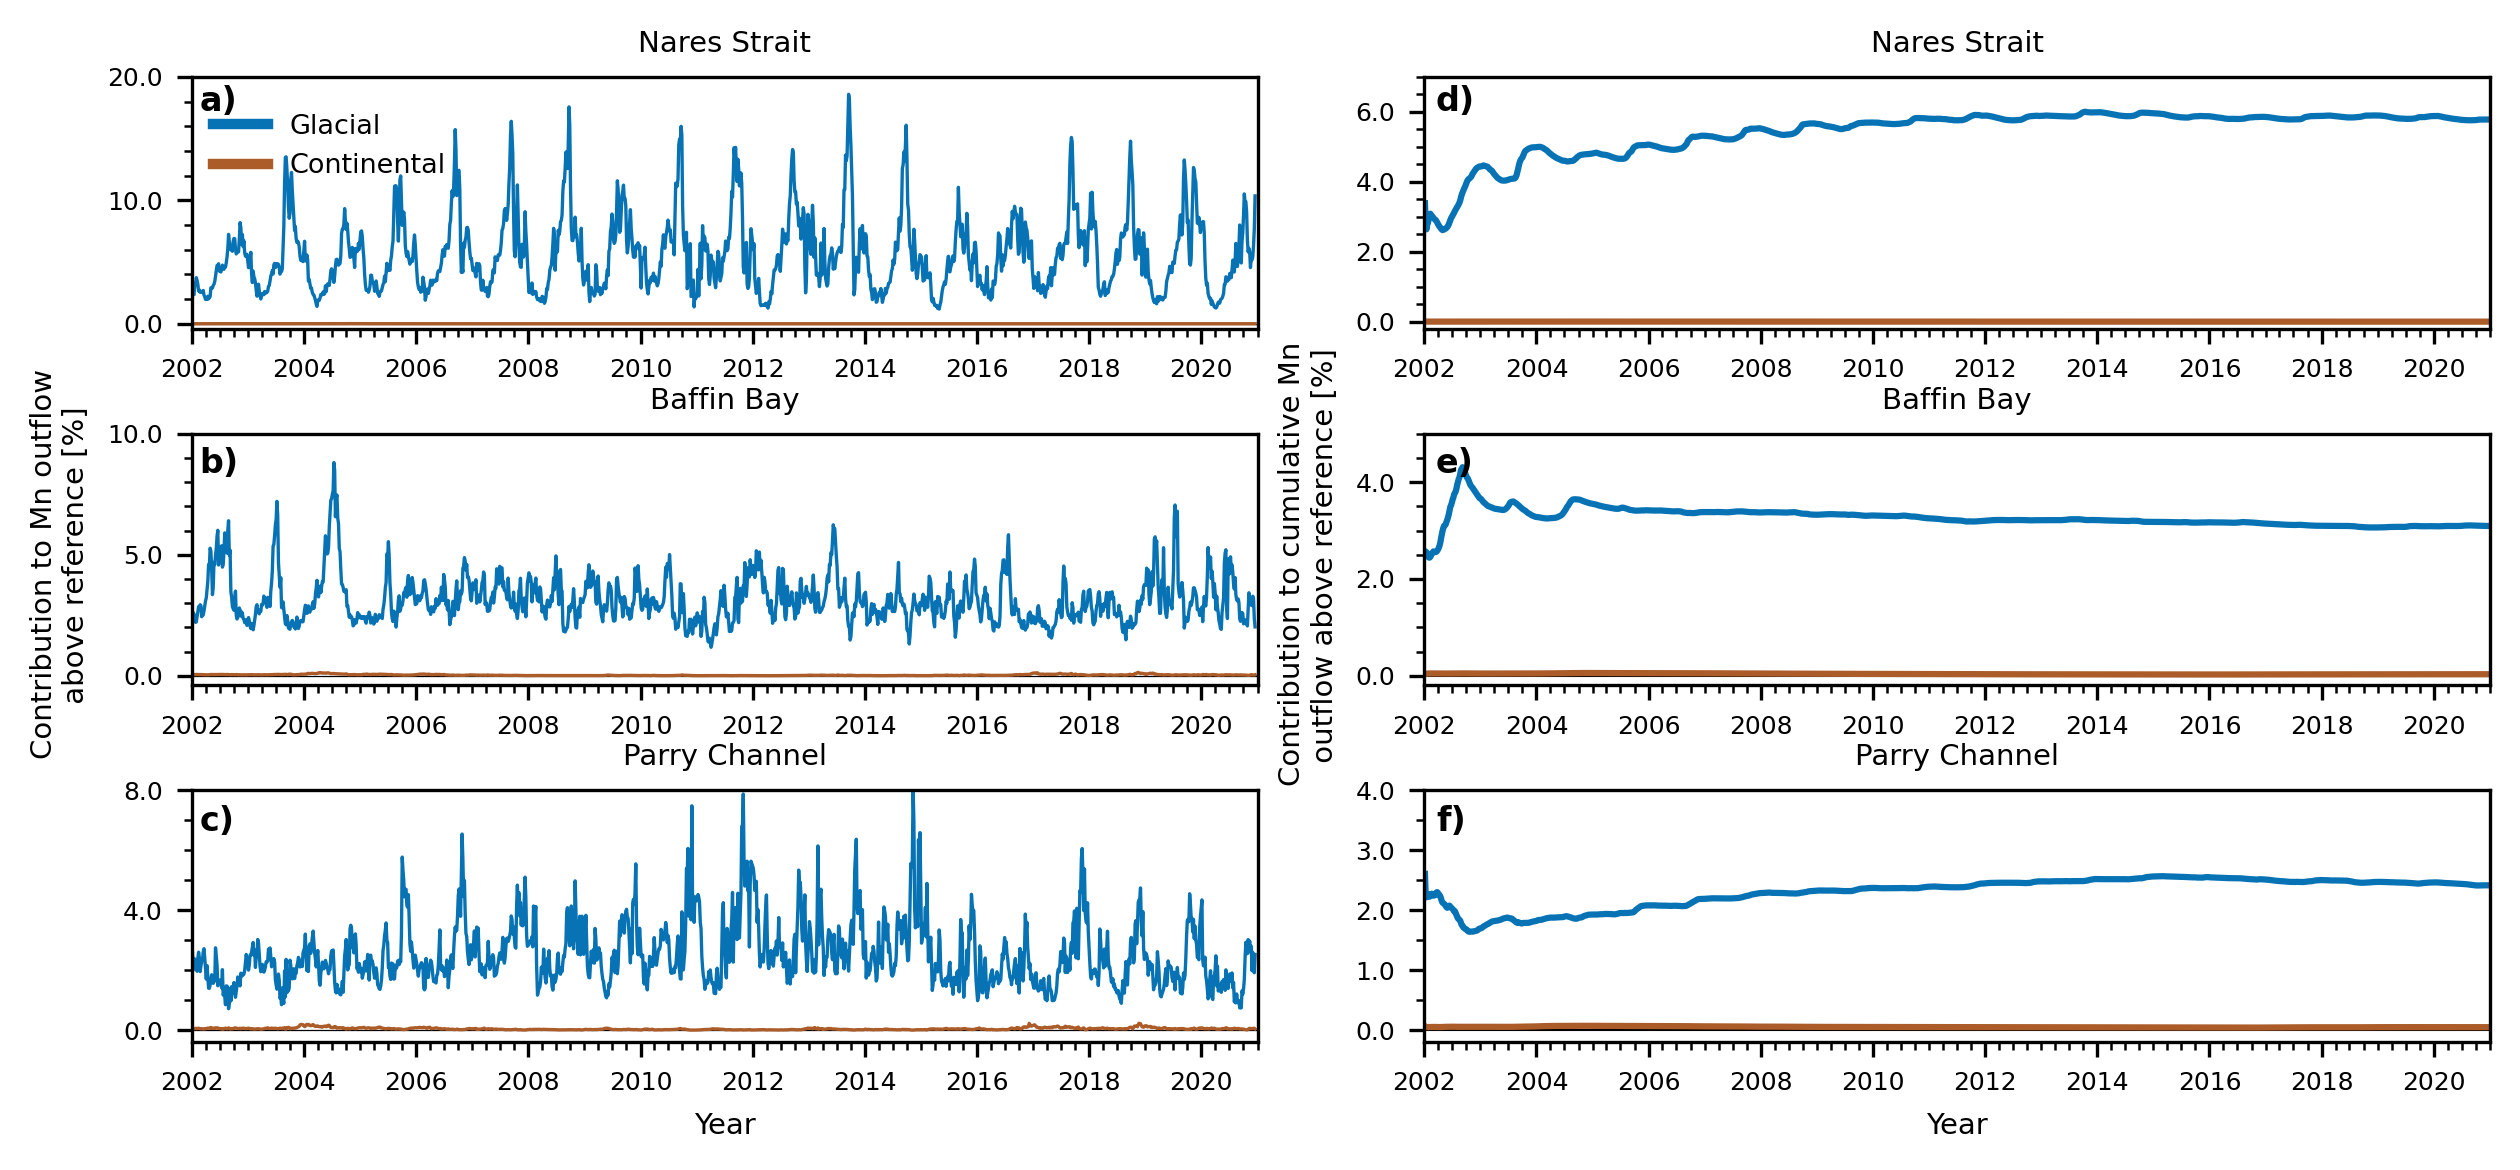

In [14]:
fig, ax = plt.subplots(3,2, figsize=(8.5,4), dpi=300)

#----------- General settings ------------------
ax[2,0].set_xlabel('Year', fontsize=7)
ax[2,1].set_xlabel('Year', fontsize=7)
ax[1,0].set_ylabel('Contribution to Mn outflow \n above reference [%]', fontsize=7)
ax[1,1].set_ylabel('Contribution to cumulative Mn \n outflow above reference [%]', fontsize=7)

for axis in ax.ravel():
    axis.tick_params(axis='both', which='major', labelsize=6)
    axis.set_xlim(dt.datetime(2002,1,1),dt.datetime(2021,1,1))
    axis.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    axis.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=(1,4,7,10)))

#----------- Nares Strait ----------------------
ax[0,0].set_title('Nares Strait', fontsize=7)
ax[0,0].set_ylim(-0.4,20)
ax[0,0].yaxis.set_major_locator(MultipleLocator(10));
ax[0,0].yaxis.set_minor_locator(MultipleLocator(2));
ax[0,0].plot([dates[0], dates[-1]],[0, 0], linewidth=0.3, color='k')
ax[0,0].plot(dates, NSS_glacial_neg    , linewidth=0.8, color=color_glac)
ax[0,0].plot(dates, NSS_continental_neg, linewidth=0.8, color=color_cont)
ax[0,0].plot([0,0], [0,0], linewidth=2.5, color=color_glac, label='Glacial')
ax[0,0].plot([0,0], [0,0], linewidth=2.5, color=color_cont, label='Continental')
ax[0,0].legend(loc=(0.01, 0.55), frameon=False, framealpha=0.5, fontsize=6.5)

ax[0,1].set_title('Nares Strait', fontsize=7)
ax[0,1].set_ylim(-0.2,7)
ax[0,1].yaxis.set_major_locator(MultipleLocator(2));
ax[0,1].yaxis.set_minor_locator(MultipleLocator(0.5));
ax[0,1].plot([dates[0], dates[-1]],[0, 0], linewidth=0.5, color='k')
ax[0,1].plot(dates, NSS_glacial_cumsum_neg    , linewidth=1.5, color=color_glac)
ax[0,1].plot(dates, NSS_continental_cumsum_neg, linewidth=1.5, color=color_cont)

#----------- Baffin Bay ------------------------
ax[1,0].set_title('Baffin Bay', fontsize=7)
ax[1,0].set_ylim(-0.4,10)
ax[1,0].yaxis.set_major_locator(MultipleLocator(5));
ax[1,0].yaxis.set_minor_locator(MultipleLocator(1));
ax[1,0].plot([dates[0], dates[-1]],[0, 0], linewidth=0.3, color='k')
ax[1,0].plot(dates, BB_glacial_neg    , linewidth=0.8, color=color_glac)
ax[1,0].plot(dates, BB_continental_neg, linewidth=0.8, color=color_cont)

ax[1,1].set_title('Baffin Bay', fontsize=7)
ax[1,1].set_ylim(-0.2, 5)
ax[1,1].yaxis.set_major_locator(MultipleLocator(2));
ax[1,1].yaxis.set_minor_locator(MultipleLocator(0.5));
ax[1,1].plot([dates[0], dates[-1]],[0, 0], linewidth=0.5, color='k')
ax[1,1].plot(dates, BB_continental_cumsum_neg , linewidth=1.5, color=color_cont)
ax[1,1].plot(dates, BB_glacial_cumsum_neg , linewidth=1.5, color=color_glac)

#----------- Parry Channel ---------------------
ax[2,0].set_title('Parry Channel', fontsize=7)
ax[2,0].set_ylim(-0.4,8)
ax[2,0].yaxis.set_major_locator(MultipleLocator(4));
ax[2,0].yaxis.set_minor_locator(MultipleLocator(1));
ax[2,0].plot([dates[0], dates[-1]],[0, 0], linewidth=0.3, color='k')
ax[2,0].plot(dates, PCE_glacial_neg    , linewidth=0.8, color=color_glac)
ax[2,0].plot(dates, PCE_continental_neg, linewidth=0.8, color=color_cont)

ax[2,1].set_title('Parry Channel', fontsize=7)
ax[2,1].set_ylim(-0.2, 4)
ax[2,1].yaxis.set_major_locator(MultipleLocator(1));
ax[2,1].yaxis.set_minor_locator(MultipleLocator(0.5));
ax[2,1].plot([dates[0], dates[-1]],[0, 0], linewidth=0.5, color='k')
ax[2,1].plot(dates, PCE_glacial_cumsum_neg , linewidth=1.5, color=color_glac)
ax[2,1].plot(dates, PCE_continental_cumsum_neg , linewidth=1.5, color=color_cont)

#---------------------------------------------
plt.tight_layout(w_pad=0.5, h_pad=-1)

# add text labels:
fig.text(0.084, 0.895, 'a)', fontsize=8, weight='bold');
fig.text(0.084, 0.593, 'b)', fontsize=8, weight='bold');
fig.text(0.084, 0.295, 'c)', fontsize=8, weight='bold');

fig.text(0.569, 0.895, 'd)', fontsize=8, weight='bold');
fig.text(0.569, 0.593, 'e)', fontsize=8, weight='bold');
fig.text(0.569, 0.295, 'f)', fontsize=8, weight='bold');

fig.savefig('/ocean/brogalla/GEOTRACES/figures/rivers-paper-202206/R6-time-series.jpg', bbox_inches='tight', dpi=300)